### **一、導入必要程式庫**

In [43]:
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, f1_score
import scipy.stats as st
import sys
import os
import random
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout, Conv2D, Lambda, Input, Bidirectional, CuDNNLSTM, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras import backend as K
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
from layers import Attention, SelfAttention
import keras
import datetime
from tqdm import tqdm, trange
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

### **二、讀取UPB的.npz檔案並做資料預處理**

**預備工作**：
* 先運行 `convert_mat_to_csv_all.py` 將UPB資料集的.mat轉換為csv檔案
* 把UPB資料集做成.npz檔案(參考 `model_self_attn_UPB.ipynb` )

In [44]:
# 讀取UPB的.npz檔案
data_input_file = 'UPB_current_vib_N09_M07_F10_data.npz'
tmp = np.load(data_input_file, allow_pickle=True)
X = tmp['X']  # (140, 250000, 3)
y_one_hot = tmp['y']  # (140, 3)

# 將陣列中的資料順序做洗牌
indices = np.random.permutation(X.shape[0])  # 生成一個隨機的索引序列

# 使用這個索引序列來重新安排 X 和 y
X_shuffled = X[indices]
y_shuffled = y_one_hot[indices]

# print(X_shuffled.shape)  # (140, 250000, 3)
# print(y_shuffled.shape)  # (140, 3)

#===============================減少數據數量的方式===================================

# 方法一：使用切片進行降採樣：在第二維每隔10個點取一個點
# X_shuffled = X_shuffled[:, ::10, :]  # (140, 25000, 3)

# 方法二：使用RMS來減少數據長度：在第二維每隔5個點取RMS
# X_shuffled_rms = np.zeros((140, 50000, 3))  # 初始化一個空陣列來儲存RMS計算後的數據

# for i in trange(140, desc='RMS Processing'):  # 遍歷每個數據集
#     for j in range(3):  # 遍歷每個特徵
#         # 對於每個特徵，將數據分組，每10筆數據一組，並計算每組的RMS
#         for k in range(50000):  # 遍歷每組數據
#             # 提取當前組的數據
#             group = X_shuffled[i, k*5:(k+1)*5, j]
#             # 計算RMS並賦值
#             X_shuffled_rms[i, k, j] = np.sqrt(np.mean(np.square(group)))

# X_shuffled = np.copy(X_shuffled_rms)

# 方法三：使用Mean來減少數據長度：在第二維每隔10個點取Mean
# X_shuffled_mean = np.zeros((140, 50000, 3))  # 初始化一個空陣列來儲存平均值計算後的數據

# for i in trange(140, desc='Mean Processing'):  # 遍歷每個數據集
#     for j in range(3):  # 遍歷每個軸
#         # 對於每個軸，將數據分組，每10筆數據一組，並計算每組的平均值
#         for k in range(50000):  # 遍歷每組數據
#             # 提取當前組的數據
#             group = X_shuffled[i, k*5:(k+1)*5, j]
#             # 計算平均值並賦值
#             X_shuffled_mean[i, k, j] = np.mean(group)

# X_shuffled = np.copy(X_shuffled_mean)

# 方法四：採用0.25s的數據
X_shuffled = X_shuffled[:, 125000:140625, :]  # (140, 15625, 3)

# 方法五：只採用振動數據
X_shuffled = X_shuffled[:, :, 2]  # (140, 15625)

# 方法六：使用FFT轉換
X_shuffled_fft = np.zeros_like(X_shuffled, dtype=np.complex)  # 初始化一個空陣列來儲存FFT結果，注意FFT結果的大小與原數據相同

for i in trange(140, desc='FFT Processing'):  # 遍歷每個數據集
    # 對每個軸的數據進行FFT轉換
    X_shuffled_fft[i, :] = np.fft.fft(X_shuffled[i, :])

X_shuffled = np.copy(np.abs(X_shuffled_fft))  # 幅度

#===================================================================================

print(X_shuffled.shape)  # (140, 15625)

# 拆解成訓練集與驗證集
X_shuffled_val = np.copy(X_shuffled[120:])  # (20, 15625)
y_shuffled_val = np.copy(y_shuffled[120:])  # (20, 3)
X_shuffled = X_shuffled[:120]  # (120, 15625)
y_shuffled = y_shuffled[:120]  # (120, 3)
print("X_shuffled_val:{}, y_shuffled_val:{}, X_shuffled:{}, y_shuffled:{}".format(X_shuffled_val.shape, y_shuffled_val.shape, X_shuffled.shape, y_shuffled.shape))

NUM_LABELS = y_one_hot.shape[1]

y = np.argmax(y_shuffled, axis=1)

# 增加維度
X_shuffled_ = np.expand_dims(X_shuffled, axis = 2)  # (120, 15625, 1)
X_shuffled_val_ = np.expand_dims(X_shuffled_val, axis = 2)  # (20, 15625, 1)
print(X_shuffled_.shape)

FFT Processing: 100%|██████████| 140/140 [00:00<00:00, 307.04it/s]


(140, 15625)
X_shuffled_val:(20, 15625), y_shuffled_val:(20, 3), X_shuffled:(120, 15625), y_shuffled:(120, 3)
(120, 15625, 1)


### **三、將輸入模型的資料作可視化**

#### **若有FFT轉換：查看頻率與振幅關係圖**

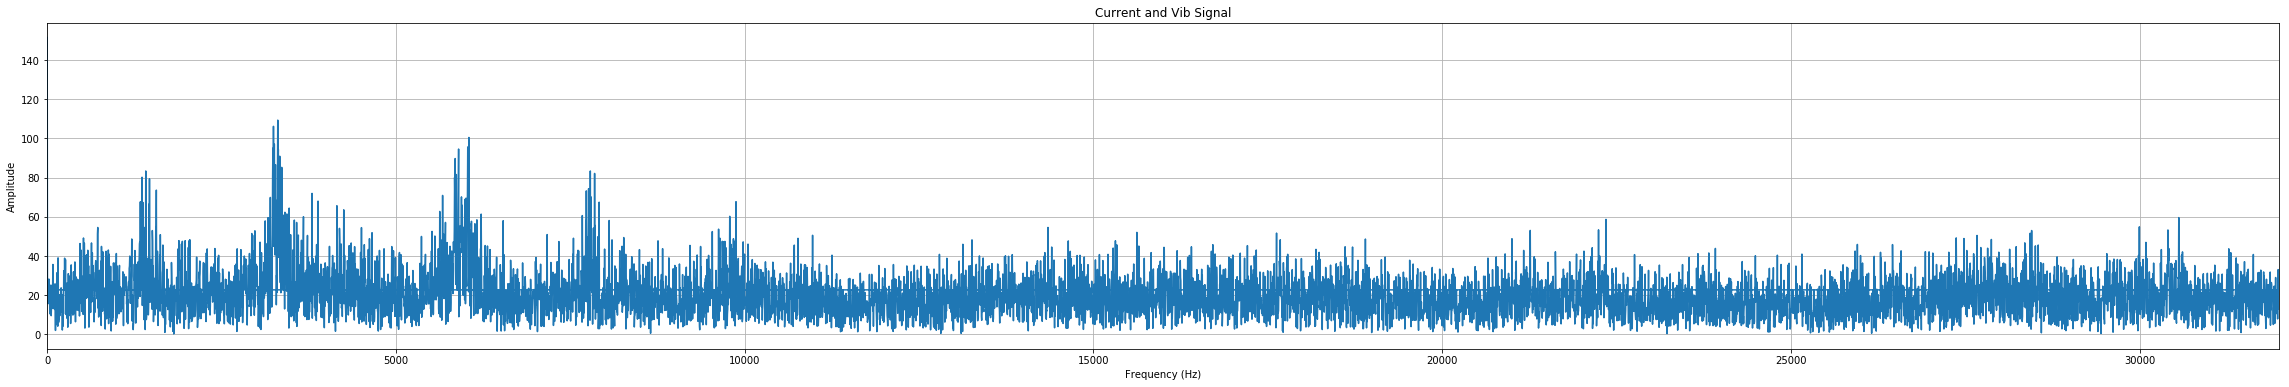

In [45]:
# 原始數據的採樣率，單位是Hz
sampling_rate = 64000

# 繪製資料分布
dataset_index = 2  # 選擇隨機排列後的第幾筆資料
dataset = X_shuffled[dataset_index, :]

# 計算頻率軸的值
N = dataset.shape[0]  # 數據點的數量
freq = np.fft.fftfreq(N, d=1/sampling_rate)

# Create a smooth line chart for the 3-axis data
plt.figure(figsize=(40, 6))
plt.plot(freq, dataset)
plt.title('Current and Vib Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim([0, sampling_rate / 2])  # 通常只顯示到Nyquist頻率
plt.grid(True)
plt.show()

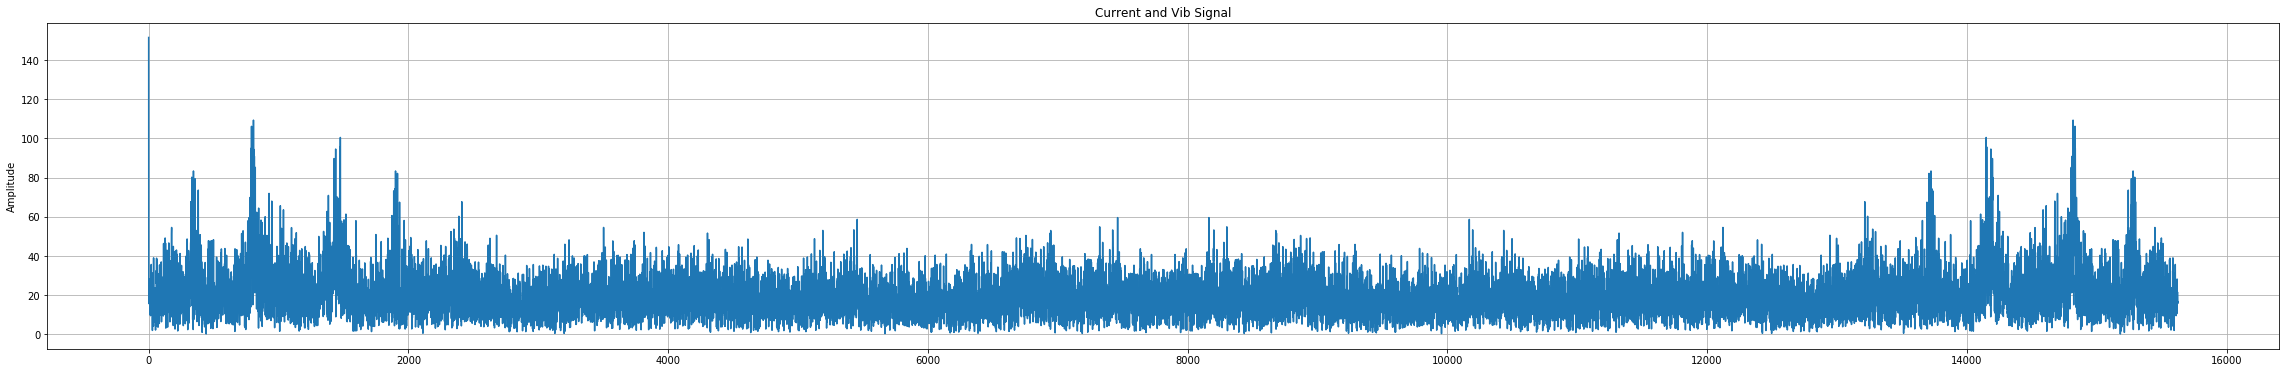

In [46]:
plt.figure(figsize=(40, 6))
plt.plot(dataset)
plt.title('Current and Vib Signal')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

##### 根據上圖來選擇資料區間

In [47]:
X_shuffled = X_shuffled[:, :5209]  # (120, 5209)  這裡取1/3
X_shuffled_val = X_shuffled_val[:, :5209]  # (20, 5209)

# 增加維度
X_shuffled_ = np.expand_dims(X_shuffled, axis = 2)  # (120, 5209, 1)
X_shuffled_val_ = np.expand_dims(X_shuffled_val, axis = 2)  # (20, 5209, 1)
print(X_shuffled_.shape)

print("X_shuffled_val:{}, y_shuffled_val:{}, X_shuffled:{}, y_shuffled:{}".format(X_shuffled_val.shape, y_shuffled_val.shape, X_shuffled.shape, y_shuffled.shape))

(120, 5209, 1)
X_shuffled_val:(20, 5209), y_shuffled_val:(20, 3), X_shuffled:(120, 5209), y_shuffled:(120, 3)


### **三、定義與訓練模型**

##### **1. 定義模型參數**

In [48]:
# 定義模型儲存路徑
SAVE_DIR = './UPB_current_vib_N09_M07_F10_model'

# 創建模型儲存路徑資料夾
if not os.path.exists(os.path.join(SAVE_DIR)):
    os.mkdir(os.path.join(SAVE_DIR))

# 定義訓練參數
EPOCH = 20
BATCH_SIZE = 8
LSTM_UNITS = 64
NN_UNITS = 64

SEED = 5
random.seed(SEED)
np.random.seed(SEED)
tf.set_random_seed(SEED)

##### **2. 建立模型與訓練**

In [49]:
# 構建模型
model = Sequential()
model.add(LSTM(LSTM_UNITS, input_shape=(5209, 1), return_sequences=False))  # LSTM層
model.add(Dropout(0.3)) # 減少模型對訓練數據的過度擬合
model.add(Dense(NN_UNITS, activation='relu'))  # 全連接層
model.add(Dense(3, activation='softmax'))  # 輸出層

# 是否要載入現有模型權重以繼續訓練
model_path = os.path.join(SAVE_DIR, 'UPB_current_vib_N09_M07_F10_model_2024-02-23_09-44-45.h5')  # 想要載入的模型檔案名
if os.path.exists(model_path):
    print("載入現有模型繼續訓練")
    model.load_weights(model_path)
else:
    print("創建新模型進行訓練")

dt = datetime.datetime.now()
model_filename = SAVE_DIR + '/UPB_current_vib_N09_M07_F10_model_' + dt.strftime("%Y-%m-%d_%H-%M-%S") + '.h5'

# 編譯模型
opt = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# 訓練模型
history = model.fit(X_shuffled_, y_shuffled, epochs=EPOCH, batch_size=BATCH_SIZE, verbose=1, validation_data=(X_shuffled_val_, y_shuffled_val))

# 儲存模型
model.save_weights(model_filename)

載入現有模型繼續訓練
Train on 120 samples, validate on 20 samples
Epoch 1/20
120/120 [==============================] - 53s 443ms/step - loss: 0.6400 - acc: 0.8000 - val_loss: 0.4962 - val_acc: 0.9000
Epoch 2/20
120/120 [==============================] - 53s 440ms/step - loss: 0.6441 - acc: 0.7667 - val_loss: 0.4868 - val_acc: 0.9000
Epoch 3/20
120/120 [==============================] - 51s 429ms/step - loss: 0.6548 - acc: 0.7833 - val_loss: 0.4841 - val_acc: 0.9000
Epoch 4/20
120/120 [==============================] - 52s 430ms/step - loss: 0.6738 - acc: 0.7750 - val_loss: 0.4668 - val_acc: 0.9000
Epoch 5/20
120/120 [==============================] - 51s 429ms/step - loss: 0.6013 - acc: 0.8083 - val_loss: 0.5162 - val_acc: 0.8500
Epoch 6/20
120/120 [==============================] - 51s 429ms/step - loss: 0.6226 - acc: 0.7750 - val_loss: 0.4587 - val_acc: 0.9000
Epoch 7/20
120/120 [==============================] - 51s 424ms/step - loss: 0.5728 - acc: 0.8083 - val_loss: 0.4683 - val_acc: 0.8500

##### **3. 繪製訓練結果**

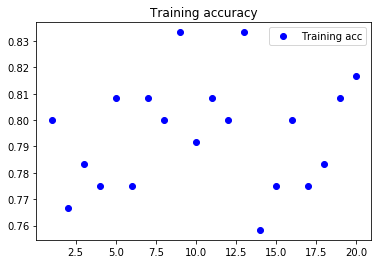

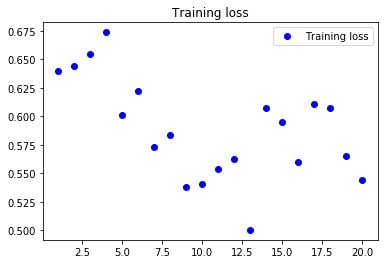

<Figure size 432x288 with 0 Axes>

In [50]:
# 繪製訓練過程
def plot_accuracy(history):
    acc = history.history['acc'] # acc是指模型訓練精度
    val_acc = history.history['val_acc'] # val_acc是指模型在驗證集上的精度
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.title('Training accuracy')
    plt.legend()
    plt.figure()

def plot_loss(history):
    loss = history.history['loss'] # loss是訓練的的損失值
    val_loss = history.history['val_loss'] # val_loss是指模型在驗證集上的損失值
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.title('Training loss')
    plt.legend()
    plt.figure()

plot_accuracy(history)
plot_loss(history)

##### **4. 在訓練集上評估模型**

120/120 [==============================] - 3s 23ms/step
Test loss: 0.45748504797617595, Test accuracy: 0.824999996026357


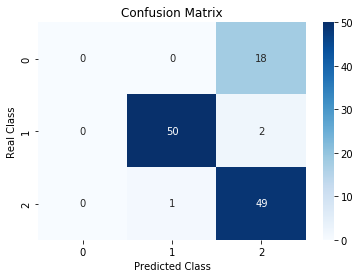

In [54]:
# 構建模型
model = Sequential()
model.add(LSTM(LSTM_UNITS, input_shape=(5209, 1), return_sequences=False))  # LSTM層
model.add(Dense(NN_UNITS, activation='relu'))  # 全連接層
model.add(Dense(3, activation='softmax'))  # 輸出層

model.load_weights('UPB_current_vib_N09_M07_F10_model/UPB_current_vib_N09_M07_F10_model_2024-02-23_10-18-27.h5')

# 編譯模型
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 評估模型
loss, accuracy = model.evaluate(X_shuffled_, y_shuffled)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

# 進行預測
predictions = model.predict(X_shuffled_)
predicted_classes = np.argmax(predictions, axis=1)

# 計算混淆矩陣
y = np.argmax(y_shuffled, axis=1)
conf_matrix = confusion_matrix(y, predicted_classes)

# 顯示混淆矩陣
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.title('Confusion Matrix')
plt.show()

##### **5. 在測試集上評估模型** 
* 先運行`convert_mat_to_csv_all.py`將UPB資料集的.mat轉換為csv檔案
* 只將轉換完的電流與振動csv檔案做成.npz檔案(先取工況Operating Parameter為：N09_M07_F10)
* 測試資料X的shape：(140, 250000, 3) --- 7個軸承編號，每個編號20個資料集，每個資料集包含振動訊號與2個電流訊號，資料數量為250000筆
* 訓練資料y的shape：(140, 3) --- 3種標籤
* 標籤：`Healthy`、`Outer ring damage`、`Inner ring damage`

**(1) 製作測試集資料的壓縮檔** 

In [56]:
import pandas as pd
import numpy as np
import os

# 轉換所有訓練資料夾
folder_names = ['K001', 'KA22', 'KA04', 'KA15', 'KI14', 'KI21', 'KI17']
operating_parameter = 'N09_M07_F10'  # 指定工況
folder_indexes = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 
                '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']

# 定義空的y_onehot
y_data_array = np.zeros((140, 3))
data_index = 0

for folder_name in folder_names:
    for folder_index in folder_indexes:
        csv_file_path = os.path.join(folder_name, f'{operating_parameter}_{folder_name}_{folder_index}', 
                                     f'{operating_parameter}_{folder_name}_{folder_index}_current_vib.csv')
        # print(csv_file_path)
        df = pd.read_csv(csv_file_path)

        # 轉換為numpy數組
        X_data_array = df.to_numpy()

        # 減去後面幾個row以達到250000筆
        n_keep = 250000
        X_data_array = X_data_array[:n_keep]  # (250000, 3)
        # print(X_data_array.shape)

        # 變為3維陣列以方便堆疊
        X_data_array = np.expand_dims(X_data_array, axis=0)  # (1, 250000, 3)
        # print(X_data_array.shape)

        # 堆疊成為大陣列
        if data_index == 0:
            X_data_array_stack = np.copy(X_data_array)

        else:
            X_data_array_stack = np.concatenate((X_data_array_stack, X_data_array), axis=0)

        print("X_data_array_stack.shape: ", X_data_array_stack.shape)

        # 製作y_onehot: Healthy[1, 0, 0], Outer ring damage[0, 1, 0], Inner ring damage[0, 0, 1]
        if folder_name == 'K001':
            y_data_array[data_index, 0] = 1

        elif folder_name == 'KA22' or folder_name == 'KA04' or folder_name == 'KA15':
            y_data_array[data_index, 1] = 1

        elif folder_name == 'KI14' or folder_name == 'KI21' or folder_name == 'KI17':
            y_data_array[data_index, 2] = 1

        print("data_index {} processed.".format(data_index))

        data_index += 1

# 使用 savez_compressed 函數壓縮儲存到一個檔案，並為每個陣列指定一個key
npz_file_path = 'UPB_current_vib_N09_M07_F10_data_test.npz'
np.savez_compressed(npz_file_path, X=X_data_array_stack, y=y_data_array)

X_data_array_stack.shape:  (1, 250000, 3)
data_index 0 processed.
X_data_array_stack.shape:  (2, 250000, 3)
data_index 1 processed.
X_data_array_stack.shape:  (3, 250000, 3)
data_index 2 processed.
X_data_array_stack.shape:  (4, 250000, 3)
data_index 3 processed.
X_data_array_stack.shape:  (5, 250000, 3)
data_index 4 processed.
X_data_array_stack.shape:  (6, 250000, 3)
data_index 5 processed.
X_data_array_stack.shape:  (7, 250000, 3)
data_index 6 processed.
X_data_array_stack.shape:  (8, 250000, 3)
data_index 7 processed.
X_data_array_stack.shape:  (9, 250000, 3)
data_index 8 processed.
X_data_array_stack.shape:  (10, 250000, 3)
data_index 9 processed.
X_data_array_stack.shape:  (11, 250000, 3)
data_index 10 processed.
X_data_array_stack.shape:  (12, 250000, 3)
data_index 11 processed.
X_data_array_stack.shape:  (13, 250000, 3)
data_index 12 processed.
X_data_array_stack.shape:  (14, 250000, 3)
data_index 13 processed.
X_data_array_stack.shape:  (15, 250000, 3)
data_index 14 processed.

In [57]:
# 測試載入壓縮檔案
data = np.load('UPB_current_vib_N09_M07_F10_data_test.npz')

# 透過指定的key來存取陣列
arr1_loaded = data['X']
arr2_loaded = data['y']

print(arr1_loaded.shape)
print(arr2_loaded.shape)

(140, 250000, 3)
(140, 3)


**(2) 讀取測試集資料並做預處理** 

In [58]:
# 讀取UPB的.npz檔案
data_input_file = 'UPB_current_vib_N09_M07_F10_data_test.npz'
tmp = np.load(data_input_file, allow_pickle=True)
X = tmp['X']  # (140, 250000, 3)
y_one_hot = tmp['y']  # (140, 3)

# 將陣列中的資料順序做洗牌
indices = np.random.permutation(X.shape[0])  # 生成一個隨機的索引序列

# 使用這個索引序列來重新安排 X 和 y
X_shuffled = X[indices]
y_shuffled = y_one_hot[indices]

# print(X_shuffled.shape)  # (140, 250000, 3)
# print(y_shuffled.shape)  # (140, 3)

#===============================減少數據數量的方式===================================

# 方法一：使用切片進行降採樣：在第二維每隔10個點取一個點
# X_shuffled = X_shuffled[:, ::10, :]  # (140, 25000, 3)

# 方法二：使用RMS來減少數據長度：在第二維每隔5個點取RMS
# X_shuffled_rms = np.zeros((140, 50000, 3))  # 初始化一個空陣列來儲存RMS計算後的數據

# for i in trange(140, desc='RMS Processing'):  # 遍歷每個數據集
#     for j in range(3):  # 遍歷每個特徵
#         # 對於每個特徵，將數據分組，每10筆數據一組，並計算每組的RMS
#         for k in range(50000):  # 遍歷每組數據
#             # 提取當前組的數據
#             group = X_shuffled[i, k*5:(k+1)*5, j]
#             # 計算RMS並賦值
#             X_shuffled_rms[i, k, j] = np.sqrt(np.mean(np.square(group)))

# X_shuffled = np.copy(X_shuffled_rms)

# 方法三：使用Mean來減少數據長度：在第二維每隔10個點取Mean
# X_shuffled_mean = np.zeros((140, 50000, 3))  # 初始化一個空陣列來儲存平均值計算後的數據

# for i in trange(140, desc='Mean Processing'):  # 遍歷每個數據集
#     for j in range(3):  # 遍歷每個軸
#         # 對於每個軸，將數據分組，每10筆數據一組，並計算每組的平均值
#         for k in range(50000):  # 遍歷每組數據
#             # 提取當前組的數據
#             group = X_shuffled[i, k*5:(k+1)*5, j]
#             # 計算平均值並賦值
#             X_shuffled_mean[i, k, j] = np.mean(group)

# X_shuffled = np.copy(X_shuffled_mean)

# 方法四：採用0.25s的數據
X_shuffled = X_shuffled[:, 125000:140625, :]  # (140, 15625, 3)

# 方法五：只採用振動數據
X_shuffled = X_shuffled[:, :, 2]  # (140, 15625)

# 方法六：使用FFT轉換
X_shuffled_fft = np.zeros_like(X_shuffled, dtype=np.complex)  # 初始化一個空陣列來儲存FFT結果，注意FFT結果的大小與原數據相同

for i in trange(140, desc='FFT Processing'):  # 遍歷每個數據集
    # 對每個軸的數據進行FFT轉換
    X_shuffled_fft[i, :] = np.fft.fft(X_shuffled[i, :])

X_shuffled = np.copy(np.abs(X_shuffled_fft))  # 幅度

#===================================================================================

print(X_shuffled.shape)  # (140, 15625)

# 拆解成訓練集與驗證集
X_shuffled_val = np.copy(X_shuffled[120:])  # (20, 15625)
y_shuffled_val = np.copy(y_shuffled[120:])  # (20, 3)
X_shuffled = X_shuffled[:120]  # (120, 15625)
y_shuffled = y_shuffled[:120]  # (120, 3)
print("X_shuffled_val:{}, y_shuffled_val:{}, X_shuffled:{}, y_shuffled:{}".format(X_shuffled_val.shape, y_shuffled_val.shape, X_shuffled.shape, y_shuffled.shape))

NUM_LABELS = y_one_hot.shape[1]

y = np.argmax(y_shuffled, axis=1)

# 增加維度
X_shuffled_ = np.expand_dims(X_shuffled, axis = 2)  # (120, 15625, 1)
X_shuffled_val_ = np.expand_dims(X_shuffled_val, axis = 2)  # (20, 15625, 1)
print(X_shuffled_.shape)

FFT Processing: 100%|██████████| 140/140 [00:00<00:00, 225.98it/s]


(140, 15625)
X_shuffled_val:(20, 15625), y_shuffled_val:(20, 3), X_shuffled:(120, 15625), y_shuffled:(120, 3)
(120, 15625, 1)


**(3) 取頻域資料的1/3** 

In [59]:
X_shuffled = X_shuffled[:, :5209]  # (120, 5209)  這裡取1/3
X_shuffled_val = X_shuffled_val[:, :5209]  # (20, 5209)

# 增加維度
X_shuffled_ = np.expand_dims(X_shuffled, axis = 2)  # (120, 5209, 1)
X_shuffled_val_ = np.expand_dims(X_shuffled_val, axis = 2)  # (20, 5209, 1)
print(X_shuffled_.shape)

print("X_shuffled_val:{}, y_shuffled_val:{}, X_shuffled:{}, y_shuffled:{}".format(X_shuffled_val.shape, y_shuffled_val.shape, X_shuffled.shape, y_shuffled.shape))

(120, 5209, 1)
X_shuffled_val:(20, 5209), y_shuffled_val:(20, 3), X_shuffled:(120, 5209), y_shuffled:(120, 3)


**(4) 載入與評估模型** 

120/120 [==============================] - 3s 25ms/step
Test loss: 1.8955848773320516, Test accuracy: 0.43333333333333335


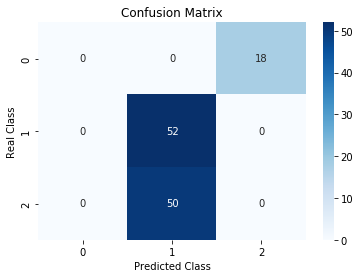

In [60]:
# 構建模型
model = Sequential()
model.add(LSTM(LSTM_UNITS, input_shape=(5209, 1), return_sequences=False))  # LSTM層
model.add(Dense(NN_UNITS, activation='relu'))  # 全連接層
model.add(Dense(3, activation='softmax'))  # 輸出層

model.load_weights('UPB_current_vib_N09_M07_F10_model/UPB_current_vib_N09_M07_F10_model_2024-02-23_10-18-27.h5')

# 編譯模型
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 評估模型
loss, accuracy = model.evaluate(X_shuffled_, y_shuffled)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

# 進行預測
predictions = model.predict(X_shuffled_)
predicted_classes = np.argmax(predictions, axis=1)

# 計算混淆矩陣
y = np.argmax(y_shuffled, axis=1)
conf_matrix = confusion_matrix(y, predicted_classes)

# 顯示混淆矩陣
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.title('Confusion Matrix')
plt.show()